# Topic Modeling with Top2Vec
* Notebook by Adam Lang
* Date: 7/17/2024

# Overview
* In this notebook we will go over using the Top2Vec library for topic modeling.

## What is Top2Vec?
* `Top2Vec` is an algorithm for **topic modeling** and **semantic search**.
* `Top2Vec` is an unsupervised algorithm just as other topic modeling algorithms are.
* `Top2Vec` wraps around a few well known NLP libraries:
   * TensorFlow
   * Gensim
   * UMAP
* It can automatically detect topics present in text and generates jointly embedded topics, document and word vectors.
* Once you train the `Top2Vec` model you can:

1. Get number of detected topics.
2. Get topics.
3. Get topic sizes.
4. Get hierarchichal topics.
5. Search topics by keywords.
6. Search documents by topic.
7. Search documents by keywords.
8. Find similar words.
9. Find similar documents.
10. Expose model with RESTful-Top2Vec

## Immediate Benefits
* Automatically finds number of topics.
* No need for manual coding and typical "classical" text preprocessing steps such as:
     * stop word lists
     * stemming/lemmatization.
* Works on short text.
* Creates jointly embedded topic, document, and word vectors.
* Built in search functions.


## Typical Top2Vec Workflow
1. Convert text to numbers
   * This is done with either:
       * Doc2Vec (Gensim - not advised)
       * Universal Sentence Encoder (TensorFlow)
       * SentenceTransformers (SBERT)
    * Creates higher dimensional vectors.

2. Dimensionality reduction with **UMAP** algorithm.
   * UMAP constructs a low-dimensional representation of the data that preserves the global and local structure of the high-dimensional space. * UMAP uses a graph-based approach to build a topological representation of the data, which is then embedded in a low-dimensional space using stochastic gradient descent.
   * The advantages of using UMAP vs. PCA:
      * PCA is linear and focuses on maximum variance in data to capture global patterns.
           * PCA is less computationally intensive.
           * PCA is more interpretable.
           * PCA is better for dimensionality reduction, feature selection, and noise reduction.
           * PCA has minimal parameters to tune.
      * UMAP is **nonlinear** and aims to preserve both **local and global** data structures, making them more suitable for visualizing and exploring complex relationships.
           * UMAP is more computationally intensive.
           * UMAP is less interpretable.
           * UMAP (and t-sNE) are better for exploratory data analysis and visualization.
           * UMAP has more intricate parameters to fine tune.

3. Find dense areas of the document(s) with **HDBSCAN** algorithm.
   * Locate semantically similar clusters.

4. Vectorization and finding Topic Vectors and Outliers
   * Vectorization is performed.
   * For each dense area calculate the centroid of document vectors in original dimension, this is the topic vector.

5. Clustering
   * Find n-closest word vectors to the resulting topic vector.

# Top2Vec Experimentation

In [1]:
## imports
import pandas as pd

## Get Dataset
* The dataset comes from the Truth and Reconciliation commission of South Africa, Vol. 7.
   * link: https://www.justice.gov.za/trc/report/

In [2]:
## import raw from github
import requests
from pathlib import Path #create file directory

# setup path to data folder
data_path = Path("data/")
file_path = data_path / "vol7"

# if the folder doesn't exist, download and prepare
if file_path.is_dir():
  print(f"{file_path} directory already exists... skipping download")
else:
  print(f"{file_path} does not exist, creating one...")
  file_path.mkdir(parents=True, exist_ok=True)


# Download the data
with open(data_path / "vol7.json", "wb") as f:
  ## raw github or API link
  request = requests.get("https://raw.githubusercontent.com/wjbmattingly/bap_sent_embedding/main/data/vol7.json")
  print("Downloading dataset....")
  f.write(request.content) # write content of request to file

data/vol7 directory already exists... skipping download


In [3]:
data_path

PosixPath('data')

In [4]:
file_path

PosixPath('data/vol7')

In [5]:
## import data
new_path = '/content/data/vol7.json'
df = pd.read_json(new_path)
df.head()

,names,descriptions
0,"AARON, Thabo Simon",An ANCYL member who was shot and severely inju...
1,"ABBOTT, Montaigne",A member of the SADF who was severely injured ...
2,"ABDUL WAHAB, Zakier",A member of QIBLA who disappeared in September...
3,"ABRAHAM, Nzaliseko Christopher",A COSAS supporter who was kicked and beaten wi...
4,"ABRAHAMS, Achmat Fardiel",Was shot and blinded in one eye by members of ...


In [6]:
## how big is the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21747 entries, 0 to 21746
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   names         21747 non-null  object
 1   descriptions  21747 non-null  object
dtypes: object(2)
memory usage: 339.9+ KB


In [7]:
df.describe()

,names,descriptions
count,21747,21747
unique,21593,19981
top,"MKHIZE, Bongani",An ANC supporter who had her house burnt down ...
freq,4,85


In [8]:
## any null?
df.isnull().sum()

names           0
descriptions    0
dtype: int64

In [9]:
## get descriptions + convert to list
docs = df.descriptions.tolist()
docs[0]

"An ANCYL member who was shot and severely injured by SAP members at Lephoi, Bethulie, Orange Free State (OFS) on 17 April 1991. Police opened fire on a gathering at an ANC supporter's house following a dispute between two neighbours, one of whom was linked to the ANC and the other to the SAP and a councillor."

## Using Top2Vec

In [10]:
## install top2vec
!pip install top2vec

In [11]:
pip install top2vec[sentence_encoders]

In [12]:
## import top2vec
from top2vec import Top2Vec

### Model Instantiation
* The Top2Vec model does some automatic steps for us:
1. **Preprocessing**
   * text normalization (lowercasing, punctuation, etc..)
   * stop word removal
   * stemming/lemma
   * etc...
2. Joint Document/Word embedding
   * Creates embeddings of each document.

3. UMAP - lower dimensions
4. Dense areas - vectors
5. Topic models

In [28]:
## instantiate the model --> pass the docs --> embedding model
model = Top2Vec(docs, workers=4, embedding_model='universal-sentence-encoder')

2024-07-17 18:45:44,683 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-07-17 18:45:50,296 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2024-07-17 18:46:21,629 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-07-17 18:46:31,975 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-07-17 18:47:07,486 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. o

## Get topic size and number

In [29]:
## get num of topics
model.get_num_topics()

158

Summary:
* The model created 158 topics.

In [30]:
## getting topic sizes
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)

[2934  866  563  511  503  469  468  440  428  382  368  321  314  312
  307  290  281  274  270  263  263  253  230  227  223  209  200  200
  192  188  184  182  177  174  173  171  168  161  160  157  154  152
  149  144  137  131  128  127  126  124  120  120  115  114  108  107
  106  104  102   98   97   95   95   94   92   91   90   89   86   85
   84   84   81   81   80   78   78   78   75   75   73   73   72   69
   67   63   63   62   59   59   58   58   57   57   57   56   56   55
   54   54   53   51   51   51   49   49   46   45   45   45   44   44
   43   42   42   42   42   41   41   41   37   36   36   35   35   35
   34   34   33   32   32   29   29   29   28   27   27   26   25   25
   25   25   24   23   23   23   21   21   21   20   20   19   19   18
   18   16   16   12]


Summary
* This gives us the entire list of topics with their sizes in each category.
* The list is descending which is ideal for modeling.

In [31]:
# topic lengths
print(topic_nums)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157]


Summary:
* This means we have 158 unique topics in our model.

In [25]:
# getting top 1 topics
topic_words, word_scores, topic_nums = model.get_topics(1)

In [26]:
## we can zip this together
for words, scores, num in zip(topic_words, word_scores, topic_nums):
  print(f"Numbers: {num}") #this is really the index
  print(f"Words: {words}")
  print(f"Scores: {scores}")

Numbers: 0
Words: ['arson' 'burning' 'durban' 'burnt' 'fire' 'incident' 'supporter'
 'protests' 'caused' 'supporters' 'violence' 'attacks' 'detonated'
 'nelspruit' 'bombing' 'sonkombo' 'protesting' 'victim' 'attacked' 'fled'
 'confrontation' 'violent' 'attackers' 'exploded' 'protest' 'severely'
 'bombed' 'intense' 'victims' 'shocks' 'cdf' 'beaten' 'shock' 'emergency'
 'groups' 'aftermath' 'sadf' 'against' 'johannesburg' 'association' 'kzp'
 'attack' 'march' 'resulted' 'disrupt' 'explosion' 'intensifying'
 'acquitted' 'charges' 'charged']
Scores: [0.26100793 0.2296865  0.22826535 0.19579808 0.1562705  0.15505962
 0.15429664 0.14682998 0.14608353 0.14305814 0.14051634 0.13967341
 0.13935351 0.13889186 0.13889048 0.1362428  0.13592264 0.13506797
 0.13488984 0.1347894  0.13411388 0.13292043 0.13127407 0.1303308
 0.12918082 0.128787   0.12813602 0.12744378 0.12718734 0.12700859
 0.1246959  0.12214465 0.12213668 0.1220937  0.12125728 0.12110069
 0.11932294 0.11909534 0.11812315 0.11769278 0.

## Search Documents by Topic

In [47]:
## document search by topic
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=20, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
  print(f"Document: {doc_id} | Score: {score:.5f}")
  print("------------------------------------")
  print(doc)
  print("------------------------------------")
  print()

Document: 18305 | Score: 0.95282
------------------------------------
An ANC supporter who was shot dead in an attack on CONTRALESA Chief Molefe’s homestead at Nqutu, KwaZulu, near Vryheid, Natal, on 7 November 1993. The attack was allegedly motivated by Molefe’s refusal to call up men in his area to defend the IFP. An IFP leader was implicated in the attack. Eleven ANC youths were killed and seven injured.
------------------------------------

Document: 20727 | Score: 0.95282
------------------------------------
An ANC supporter who was shot dead in an attack on CONTRALESA Chief Molefe’s homestead at Nqutu, KwaZulu, near Vryheid, Natal, on 7 November 1993. The attack was allegedly motivated by Molefe’s refusal to call up men in his area to defend the IFP. An IFP leader was implicated in the attack. Eleven ANC youths were killed and seven injured.
------------------------------------

Document: 20115 | Score: 0.95282
------------------------------------
An ANC supporter who was shot de

Summary:
* We can see each document in the cluster.
* We can see the similarity score based on the centroid of the cluster.
* There is also overlap in the topics.
* This is not keyword based but semantic based (embeddings).

## Getting keywords for each topic

In [32]:
model.topic_words

array([['anc', 'johannesburg', 'durban', ..., 'vigil', 'conflict',
        'committee'],
       ['anc', 'mandela', 'johannesburg', ..., 'linked', 'injuring',
        'alleged'],
       ['anc', 'elections', 'election', ..., 'conflict', 'rally',
        'wounded'],
       ...,
       ['security', 'operation', 'operations', ..., 'arm', 'seen',
        'civilian'],
       ['amnesty', 'wounded', 'anc', ..., 'paralysed', 'opened', 'blast'],
       ['amnesty', 'activists', 'protesters', ..., 'councillor',
        'severe', 'incident']], dtype='<U14')

In [33]:
## looking at 1st index topic
model.topic_words[0]

array(['anc', 'johannesburg', 'durban', 'mandela', 'soweto', 'supporters',
       'attacked', 'association', 'supporter', 'clashes', 'pretoria',
       'activists', 'teargas', 'violence', 'arson', 'supporting',
       'victims', 'stabbed', 'ladysmith', 'mpumalanga', 'looted',
       'incident', 'councillors', 'attackers', 'elections', 'sustained',
       'property', 'rally', 'injured', 'victim', 'massacre', 'natal',
       'activist', 'election', 'zim', 'dispute', 'violent', 'severe',
       'killings', 'deaths', 'caused', 'operation', 'stadium', 'killed',
       'perpetrator', 'political', 'protests', 'vigil', 'conflict',
       'committee'], dtype='<U14')

## Creating WordClouds for the Topics

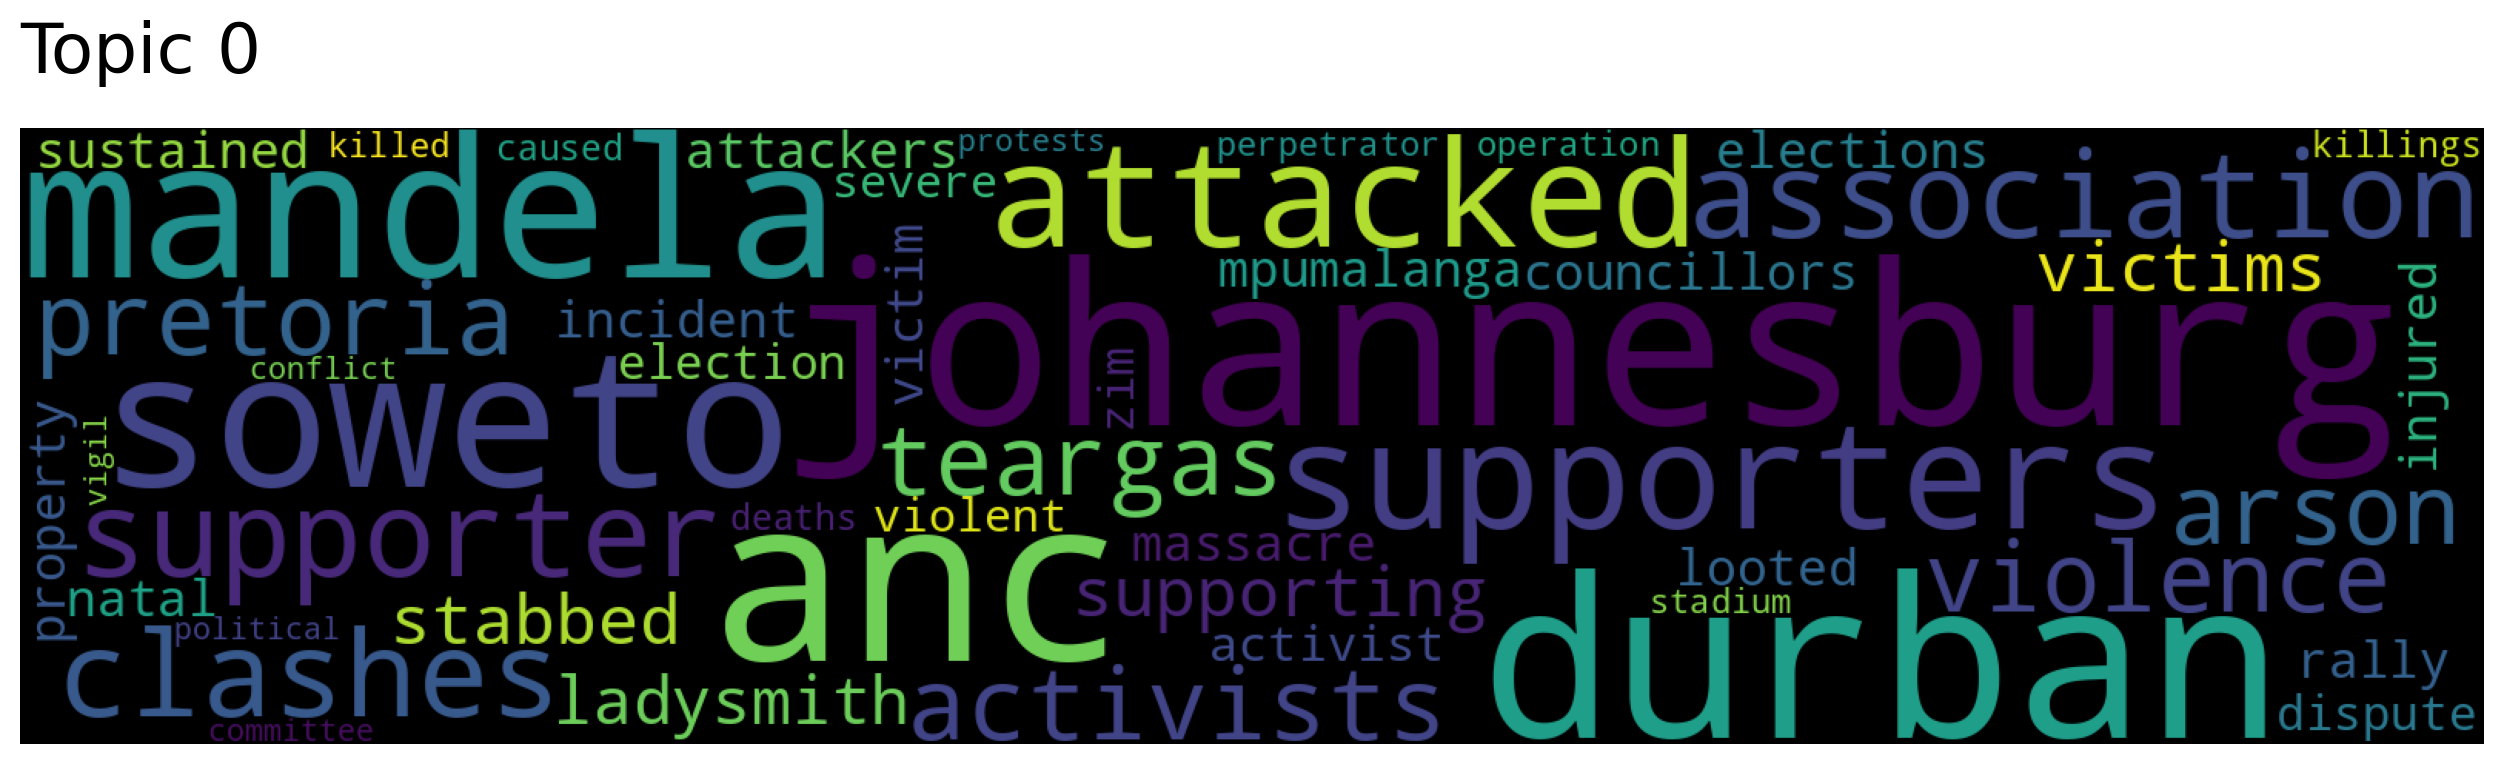

In [34]:
model.generate_topic_wordcloud(0)

Summary:
* We created a wordcoud for the 1st topic which had the most words.

## Access Topic Vectors

In [35]:
model.topic_vectors

array([[ 0.02405578,  0.0712928 , -0.04971679, ..., -0.01308359,
        -0.07533536, -0.07478402],
       [-0.00348009,  0.06108615, -0.04372508, ...,  0.00085346,
        -0.06150028, -0.07853779],
       [-0.01855657,  0.052252  , -0.0546353 , ..., -0.00162791,
        -0.0630971 , -0.07045498],
       ...,
       [-0.01712392,  0.0342016 , -0.05814638, ..., -0.01402944,
         0.02599812, -0.01360721],
       [-0.00895685,  0.04420571, -0.03451512, ...,  0.01469166,
        -0.0324017 , -0.07093669],
       [-0.04692274,  0.05799193, -0.03380192, ..., -0.02675881,
        -0.02410953, -0.03454603]], dtype=float32)

## Keyword Search by Topic

In [38]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=['attacked'], num_topics=3)

In [39]:
## print topic_words and topic_scores
topic_words, topic_scores

([array(['attacked', 'attacks', 'attackers', 'injured', 'victim', 'attack',
         'injuring', 'assaulted', 'incident', 'anc', 'stabbed', 'massacre',
         'defence', 'perpetrators', 'targeted', 'perpetrator', 'victims',
         'injuries', 'robbery', 'wounded', 'deaths', 'vigilantes',
         'vigilante', 'caused', 'killed', 'security', 'fatally',
         'johannesburg', 'retaliation', 'violence', 'unidentified',
         'involvement', 'shootings', 'damage', 'severe', 'killings',
         'youths', 'attempted', 'strike', 'activist', 'involved', 'soweto',
         'suspected', 'association', 'raped', 'operation', 'mandela',
         'against', 'ambushed', 'member'], dtype='<U14'),
  array(['attacked', 'petrol', 'explosion', 'attacks', 'detonated',
         'teargas', 'bomb', 'bombed', 'bombing', 'caused', 'assaulted',
         'injured', 'anc', 'damage', 'attack', 'victims', 'blast',
         'explosive', 'incident', 'victim', 'security', 'arson', 'defence',
         'election

## Reducing number of topics
* We can reduce the number of topics created from 158 to 20 or whatever is desired.
* Reduces the number of topics discovered by Top2Vec.
   * The most representative topics of the corpus will be found, by
iteratively merging each smallest topic to the most similar topic until
num_topics is reached.

In [48]:
topic_map = model.hierarchical_topic_reduction(num_topics=20)

In [50]:
## 5th index
topic_map[5]

[61, 34, 23, 97, 121, 43, 74, 77, 96, 112, 3]

In [52]:
model.topic_words_reduced[5]

array(['shootings', 'incident', 'activists', 'massacre', 'protests',
       'wounded', 'injuring', 'injured', 'teargas', 'victims', 'stabbed',
       'killed', 'victim', 'violence', 'died', 'police', 'protesters',
       'injuries', 'deaths', 'attacked', 'funeral', 'unrest', 'assaulted',
       'fatally', 'vigil', 'shooting', 'ambushed', 'political',
       'killings', 'executed', 'suffered', 'gunmen', 'interrogated',
       'confrontation', 'uprising', 'looted', 'killing', 'constables',
       'vigilantes', 'policemen', 'operation', 'protesting', 'armed',
       'clashes', 'violent', 'execution', 'raped', 'protest', 'occurred',
       'constable'], dtype='<U13')

# Appendix

## References
* Top2Vec github: https://github.com/ddangelov/Top2Vec
* Dimensionality Reduction : PCA, tSNE, UMAP. link: https://aurigait.com/blog/blog-easy-explanation-of-dimensionality-reduction-and-techniques/